#  프로젝트: 뉴스기사 요약해보기

In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

In [133]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [134]:
data.sample(10)

,headlines,text
74836,Javelin thrower says Indian fed told him to qu...,Davinder Singh Kang has claimed that Athletics...
9021,I'm not scared: Actress shares chat of man see...,Actress Neha Saxena has made public the messag...
43128,"Theme song for Varun Dhawan, Banita starrer Oc...",The theme song for the Varun Dhawan and Banita...
73324,Federal Reserve rebukes Trump over plan to lif...,"The US Federal Reserve head, Janet Yellen, on ..."
38586,Visited ailing ex-PM Vajpayee as I'm Congress ...,"Addressing Congress workers in Maharashtra, pa..."
56710,Fake porn video of Wonder Woman actress Gal em...,"A fake porn video of actress Gal Gadot, known ..."
25525,England end India's longest ODI series winning...,England defeated India in the third ODI on Tue...
55132,"Want Santa to gift pollution-free Christmas, N...","Actor Varun Dhawan, who celebrated Christmas a..."
96741,"Girl child buried alive, rescued by villagers ...","A newborn female, wrapped in a cloth and burie..."
9042,Milky Way star on brink of gamma-ray explosion...,Australian scientists claim to have discovered...


# Step 2. 데이터 전처리하기 (추상적 요약)

## 중복 값, null 값 제거

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


> 유일한 데이터 갯수 확인은 [].nunique() 함수로 사용

In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


> 데이터명.drop_duplicates() 하면 중복되는 데이터를 삭제해줌

drop_duplicates()으로 중복된 데이터 삭제해도 null값이 남아 있을수 있으므로, isnull()함수로 한번 더 확인해보자

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [16]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
      # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

> 함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headline에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.

In [20]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was for my mother and father.'

temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered mother father
great way to start the day


In [21]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [22]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered mother father
great way to start the day


In [23]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [24]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

In [25]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [26]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


## 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

In [ ]:
> 근데 왜 최대 길이를 구해야하는건지 좀 의아함

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


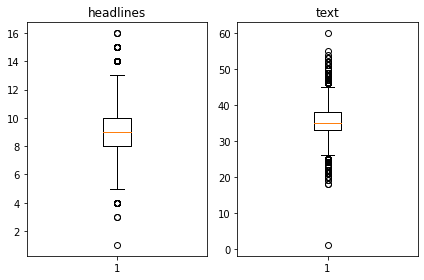

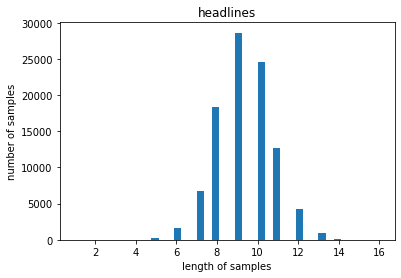

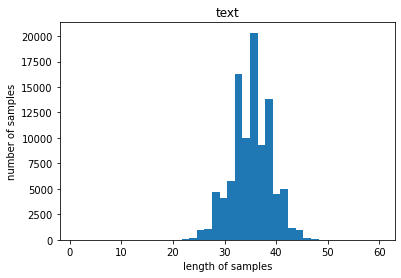

In [28]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
text_max_len = 35
headlines_max_len = 9

> 일단 먼저 임의의 길이를 내가 정하는거고, 아래의 함수를 통해서 전체 데이터에서 차지하는 %를 보여줄거임. 함수값에 따라 변경해주면 됨.

In [33]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [34]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 35 이하인 샘플의 비율: 0.5412464416429443
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.5666022773485156


> 전체 샘플 중 차지하는 비율이 너무 적으므로 값을 변경해줘야 할듯

In [35]:
text_max_len = 40
headlines_max_len = 10

In [37]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


> 0.9, 그리고 0.8 이상이므로 text_max_len = 40으로, headlines_max_len = 10으로 설정하는게 좋을듯

In [42]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 25130


> 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

## 시작 토큰과 종료 토큰 추가하기

In [43]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [44]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

> 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들거임

In [87]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(len(indices))

25130


In [88]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [89]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 5026


In [90]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 20104
훈련 레이블의 개수 : 20104
테스트 데이터의 개수 : 5026
테스트 레이블의 개수 : 5026


## 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

## 먼저 Text 단어집합 만들기

In [91]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

> Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음. 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장됨

In [92]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40428
등장 빈도가 6번 이하인 희귀 단어의 수: 29318
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11110
단어 집합에서 희귀 단어의 비율: 72.51904620560008
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.67205196631642


> src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

> threshold 값은 임의로 저장하는 건가??

In [93]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 22000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [94]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[179, 2650, 137, 368, 588, 150, 650, 336, 6295, 1103, 38, 878, 4464, 191, 181, 588, 134, 2558, 19190, 588, 2130, 4195, 656, 3959, 4196, 9360, 101, 99, 7725, 949, 137, 6], [257, 719, 1660, 24, 4066, 283, 2131, 53, 1312, 19191, 41, 25, 2976, 4894, 283, 804, 1915, 3685, 1031, 5225, 1897, 7322, 283, 378, 536, 304, 228], [72, 22, 206, 1487, 4197, 657, 879, 962, 1082, 105, 651, 1225, 3520, 651, 11111, 527, 269, 49, 2398, 1346, 8175, 6604, 1661, 120, 3609, 1188, 657, 2805, 651, 11111, 32, 252, 8176, 651, 1296, 270, 32, 879, 337]]


> 텍스드가 정수로 변환되어 나오고 있는 모습

## headlines 단어집합 만들기

In [95]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [96]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18165
등장 빈도가 5번 이하인 희귀 단어의 수: 13781
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4384
단어 집합에서 희귀 단어의 비율: 75.86567575006882
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.66481497555189


In [97]:
tar_vocab = 6000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 989, 1067, 213, 322, 1697, 569], [1, 555, 2192, 53, 347, 2851, 164, 11, 43], [1, 3867, 2852, 446, 2853, 556], [1, 215, 905, 5040, 149, 1423, 83, 695, 309], [1, 295, 18, 197, 650, 52, 773, 50]]
target
decoder  [[989, 1067, 213, 322, 1697, 569, 2], [555, 2192, 53, 347, 2851, 164, 11, 43, 2], [3867, 2852, 446, 2853, 556, 2], [215, 905, 5040, 149, 1423, 83, 695, 309, 2], [295, 18, 197, 650, 52, 773, 50, 2]]


정상적으로 정수 인코딩 작업이 끝났음. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 6,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 headlines의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

headline에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 headlines인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 headlines의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 headlines의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [99]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 20103
훈련 레이블의 개수 : 20103
테스트 데이터의 개수 : 5026
테스트 레이블의 개수 : 5026


## 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 함. 아까 정해두었던 최대 길이로 패딩 해 주면 됨! 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [100]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

여기까지가 텍스트 전처리 끝!

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

## 모델설계하기

## 인코더 먼저 설계

In [102]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 디코더 설계

In [103]:
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

## 디코더의 출력층 설계

In [104]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘

In [105]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [106]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

In [107]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
79/79 [==============================] - 38s 130ms/step - loss: 5.6081 - val_loss: 4.9982
Epoch 2/50
79/79 [==============================] - 9s 114ms/step - loss: 5.1321 - val_loss: 4.8224
Epoch 3/50
79/79 [==============================] - 9s 116ms/step - loss: 4.9375 - val_loss: 4.6993
Epoch 4/50
79/79 [==============================] - 9s 115ms/step - loss: 4.7990 - val_loss: 4.6013
Epoch 5/50
79/79 [==============================] - 9s 115ms/step - loss: 4.6624 - val_loss: 4.5016
Epoch 6/50
79/79 [==============================] - 9s 116ms/step - loss: 4.5152 - val_loss: 4.4200
Epoch 7/50
79/79 [==============================] - 9s 117ms/step - loss: 4.3746 - val_loss: 4.3230
Epoch 8/50
79/79 [==============================] - 9s 118ms/step - loss: 4.2359 - val_loss: 4.2413
Epoch 9/50
79/79 [==============================] - 9s 119ms/step - loss: 4.1081 - val_loss: 4.1850
Epoch 10/50
79/79 [==============================] - 9s 118ms/step - loss: 3.9828 - val_loss: 4.142

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.
> es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

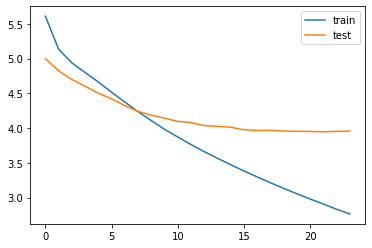

In [108]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

## 인퍼런스 모델 구현하기

In [109]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

> 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함!!

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [110]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계!!

In [111]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [112]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # 에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

> 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

## 모델 테스트하기

In [113]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [114]:
encoder_input_test[1111]

array([ 1282,   103,  5513,  6125,   533,     7,  8370,   825,  4313,
        2428,  2126,    50,  6955,   192,    12,  1004, 21857,   509,
         556,    32,  1658,  3225,  2428,  2568,  5513,    92,   119,
           6,  6408,  8689,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [115]:
seq2text(encoder_input_test[1111])

'hollywood actress jennifer lawrence slammed people mocking wearing revealing dress winter day promotions upcoming film red sparrow outside minutes would stood snow dress choice jennifer wrote facebook added sexist feminism '

In [121]:
encoder_input_test[1]

array([18834,  4389,  9503,    90,   334, 10200,    12,    92,  1134,
         150,    12, 12368,  9994,     1,   150,     3,     3,   334,
           1,  1988,    12,  1096,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [124]:
for i in range(0, 20):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : granite slab erected honour martyr major sandeep bengaluru vandalised unidentified people sunday karnataka deputy chief minister parameshwara expressed shock incident instructed city commissioner restore structure major rescued hostages taj mahal hotel mumbai terror attacks 
실제 요약 : martyr sandeep damaged in luru 
예측 요약 :  of cow slaughter in bihar


원문 : conjuring spin nun released today dull film wrote hindustan times film relies solely said times india india today said everything film rated 
실제 요약 : the off the hits theatres 
예측 요약 :  first look from akshay kumar starrer out


원문 : cbi booked unnamed officials external affairs ministry allegedly fraudulently withdrawing lakhs various general provident fund accounts amount withdrawn august february matter came light june transaction withdraw lakh stopped bank due account holder name 
실제 요약 : cbi books mea officials for withdrawal worth 
예측 요약 :  non subsidised lpg cylinder price by


원문 : gurugram headquartered online hotel aggr

# Step 5. Summa을 이용해서 추출적 요약해보기

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공

In [131]:
import requests
from summa.summarizer import summarize

In [138]:
for i in range(0, 15):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", summarize(data['text'][i], ratio=0.4))
    
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai